Este modelo usa visão computacional para identificar doenças em folhas de maçã, batata, milho e tomate, além de distinguir plantas saudáveis.

dataset: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data


In [ ]:
from platform import python_version
print(f'A versão em uso é {python_version()}.')

A versão em uso é 3.12.11.


In [1]:
from google.colab import files
files.upload()  # escolha o kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubensrochabrandao","key":"7b2560ae317a480c96d88190242f6f5b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip -d plant_disease_dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: plant_disease_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: plant_disease_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: plant_disease_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: plant_disease_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: plant_disease_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/

In [4]:
import os
import shutil

# Caminhos corretos para as pastas de treino e validação
train_dir = "/content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Plantas que vamos manter
keep_plants = ["Apple", "Corn_(maize)", "Potato", "Tomato"]

# Classes específicas de tomate que queremos manter
keep_tomato_classes = [
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___healthy"
]

def filter_dataset(data_dir, keep_plants, keep_tomato_classes):
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            plant_name = folder.split("___")[0]

            # Se não for uma das plantas desejadas → remove
            if plant_name not in keep_plants:
                print(f"❌ Removendo {folder_path}")
                shutil.rmtree(folder_path)

            # Se for tomate mas não estiver na lista de classes mantidas → remove
            elif plant_name == "Tomato" and folder not in keep_tomato_classes:
                print(f"❌ Removendo {folder_path}")
                shutil.rmtree(folder_path)

# Aplica o filtro em treino e validação
filter_dataset(train_dir, keep_plants, keep_tomato_classes)
filter_dataset(valid_dir, keep_plants, keep_tomato_classes)

print("✅ Dataset filtrado com sucesso!")



❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Blueberry___healthy
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Black_rot
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___healthy
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Esca_(Black_Measles)
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___healthy
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Squash___Powdery_mildew
❌ Removendo /content/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augment

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
img_size = 224
batch_size = 32

base_dir = "plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 24063 images belonging to 16 classes.
Found 6007 images belonging to 16 classes.


In [7]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # congela camadas da base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
out = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,590,032 (9.88 MB)

 Trainable params: 332,048 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [10]:
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [11]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8393 - loss: 0.5104
Epoch 1: val_accuracy improved from -inf to 0.93458, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 111s 111ms/step - accuracy: 0.8395 - loss: 0.5098 - val_accuracy: 0.9346 - val_loss: 0.1817
Epoch 2/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9602 - loss: 0.1169
Epoch 2: val_accuracy improved from 0.93458 to 0.94490, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.9601 - loss: 0.1169 - val_accuracy: 0.9449 - val_loss: 0.1577
Epoch 3/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9757 - loss: 0.0729
Epoch 3: val_accuracy did not improve from 0.94490
752/752 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9757 - loss: 0.0729 - val_accuracy: 0.9402 - val_loss: 0.1748
Epoch 4/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9792 - loss: 0.0578
Epoch 4: val_accuracy improved from 0.94490 to 0.95022, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9792 - loss: 0.0578 - val_accuracy: 0.9502 - val_loss: 0.1523
Epoch 5/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9861 - loss: 0.0443
Epoch 5: val_accuracy did not improve from 0.95022
752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9861 - loss: 0.0443 - val_accuracy: 0.9496 - val_loss: 0.1560
Epoch 6/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9846 - loss: 0.0439
Epoch 6: val_accuracy improved from 0.95022 to 0.95688, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.9846 - loss: 0.0439 - val_accuracy: 0.9569 - val_loss: 0.1316
Epoch 7/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9879 - loss: 0.0323
Epoch 7: val_accuracy improved from 0.95688 to 0.95755, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9879 - loss: 0.0323 - val_accuracy: 0.9575 - val_loss: 0.1386
Epoch 8/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9893 - loss: 0.0294
Epoch 8: val_accuracy did not improve from 0.95755
752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9893 - loss: 0.0294 - val_accuracy: 0.9527 - val_loss: 0.1772
Epoch 9/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9937 - loss: 0.0201
Epoch 9: val_accuracy improved from 0.95755 to 0.96254, saving model to best_model.h5


752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9625 - val_loss: 0.1402
Epoch 10/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9952 - loss: 0.0143
Epoch 10: val_accuracy did not improve from 0.96254
752/752 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9374 - val_loss: 0.2575
Epoch 11/15
751/752 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9947 - loss: 0.0196
Epoch 11: val_accuracy did not improve from 0.96254
752/752 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9947 - loss: 0.0197 - val_accuracy: 0.9551 - val_loss: 0.1676
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


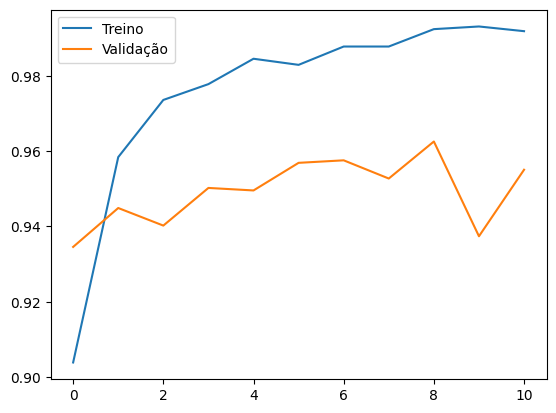

In [12]:
plt.plot(history.history['accuracy'], label="Treino")
plt.plot(history.history['val_accuracy'], label="Validação")
plt.legend()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.98      0.97       403
                                 Apple___Black_rot       0.98      0.99      0.99       397
                          Apple___Cedar_apple_rust       1.00      0.96      0.98       352
                                   Apple___healthy       0.98      1.00      0.99       401
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.88      0.92       328
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       381
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.96      0.93       381
                            Corn_(maize)___healthy       0.99      1.00      1.00       371
                             Potato___Early_blight       0.98      0.99      0.99       387
                              Potato

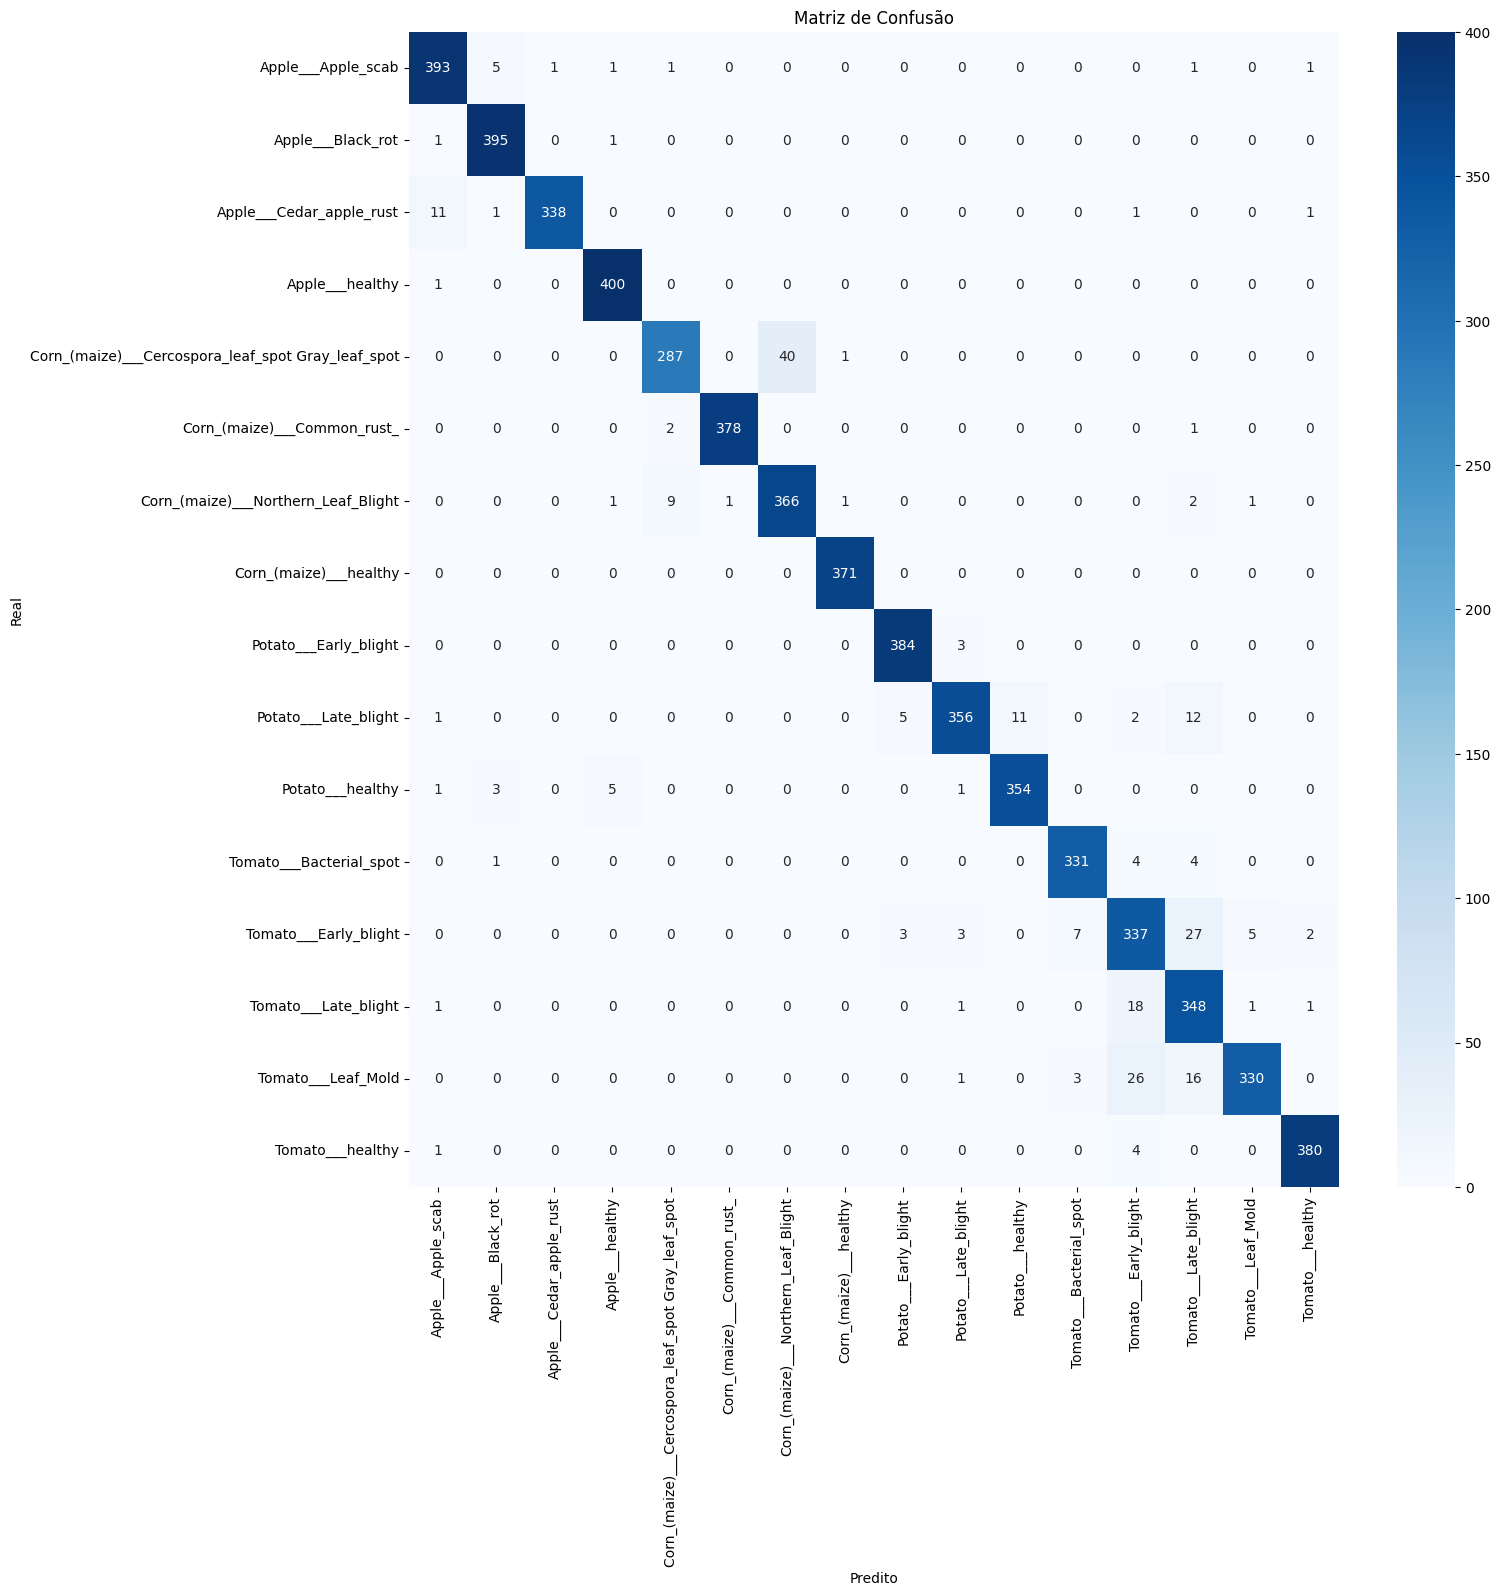

In [13]:
# Predições
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Relatório de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,       # adiciona os valores nas células
    fmt="d",          # formato inteiro
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [41]:
from google.colab import files
import os

# Cria a pasta se não existir
os.makedirs("test_images", exist_ok=True)

# Upload de imagens locais para a pasta test_images
uploaded = files.upload()
for fname in uploaded.keys():
    os.rename(fname, f"test_images/{fname}")

Saving PotatoEarlyBlight1.JPG to PotatoEarlyBlight1.JPG


In [46]:
# Aqui você troca o nome da imagem que quer testar
fname = "test_images/Image1MCR.jpeg"

In [47]:
from tensorflow.keras.preprocessing import image

# Carregar e redimensionar a imagem
img = image.load_img(fname, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

In [48]:
# Predição do modelo
pred = model.predict(img_array)[0]  # vetor de probabilidades
pred_class = np.argmax(pred)
class_name = list(train_gen.class_indices.keys())[pred_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


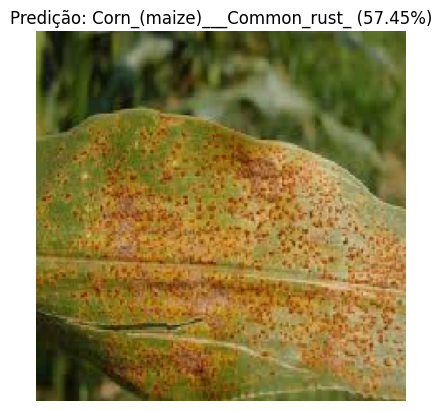

In [49]:
import matplotlib.pyplot as plt

# Mostrar a imagem e a classe prevista
plt.imshow(img)
plt.axis("off")
plt.title(f"Predição: {class_name} ({pred[pred_class]*100:.2f}%)")
plt.show()

In [50]:
# Exibir a distribuição de probabilidades
print(f"📌 Arquivo: {fname}")
print(f"➡️ Classe prevista: {class_name} ({pred[pred_class]*100:.2f}%)\n")

print("🔎 Distribuição de probabilidades:")
for i, c in enumerate(train_gen.class_indices.keys()):
    print(f"{c}: {pred[i]*100:.2f}%")

print("\n" + "="*60 + "\n")

📌 Arquivo: test_images/Image1MCR.jpeg
➡️ Classe prevista: Corn_(maize)___Common_rust_ (57.45%)

🔎 Distribuição de probabilidades:
Apple___Apple_scab: 1.33%
Apple___Black_rot: 0.00%
Apple___Cedar_apple_rust: 2.57%
Apple___healthy: 0.00%
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.12%
Corn_(maize)___Common_rust_: 57.45%
Corn_(maize)___Northern_Leaf_Blight: 38.50%
Corn_(maize)___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.02%
Tomato___Late_blight: 0.00%
Tomato___Leaf_Mold: 0.00%
Tomato___healthy: 0.00%


